# Importing libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.transform import resize
from skimage.filters import threshold_mean
from tqdm import tqdm

# Functions

In [2]:
def plot(a,ix,iy):
    a=a.reshape(ix,iy)
    plt.imshow(a,cmap='viridis')
    plt.axis('off')
    
def imageprepare(image,ix,iy):
  image=resize(image,(ix,iy),mode='reflect')
  image=(image>threshold_mean(image))*2-1
  image=np.reshape(image,ix*iy)
  return image

# Image preparation

In [3]:
ix=84
iy=84
it = 1

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

trainImg = []
for i in range(9):
    digit_positions = np.where(y_train == i)[0]
    trainImg.append(x_train[digit_positions[0]])

num_data =  9
num_neuron = 84*84

In [4]:
def create_noise_image(images, noise_ratio = 0.2):
    noisy_images = []

    for i in range(len(trainImg)):
        noisy_images.append(skimage.util.random_noise(images[i], mode='gaussian',clip=False,var=noise_ratio))
    
    test=[]
    train=[]
    for i in range(9):
        j=i%9
        img=np.ones([ix,iy])
        img[(j%3)*28:((j%3)+1)*28,int(j/3)*28:((int(j/3))+1)*28]=imageprepare(trainImg[i], 28, 28).reshape(28,28)
        train.append(img.copy())
        img[(j%3)*28:((j%3)+1)*28,int(j/3)*28:((int(j/3))+1)*28]=imageprepare(noisy_images[i], 28, 28).reshape(28,28)
        test.append(img.copy())

    train=np.array(train)
    test=np.array(test)

    train=train.reshape(9,84*84)
    test=test.reshape(9,84*84)
    
    return train, test

In [5]:
train, test = create_noise_image(trainImg)

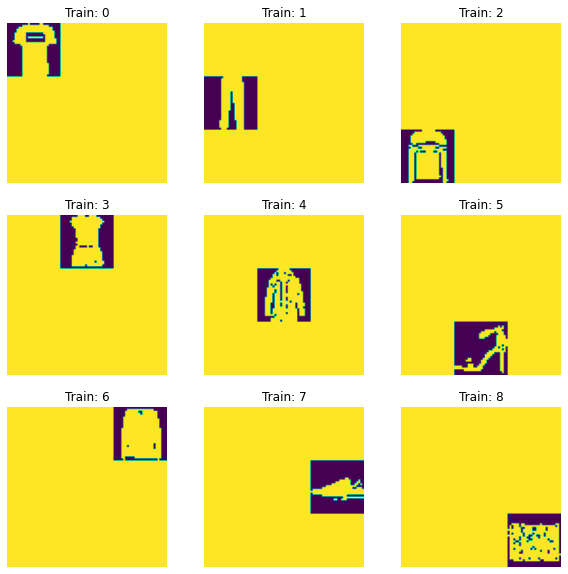

In [6]:
# Display the train set
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plot(train[i],ix,iy)
    plt.title("Train: %i" % i)
plt.show()

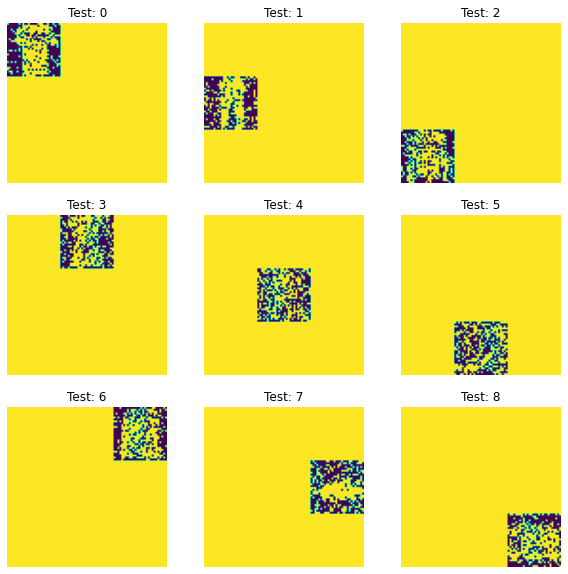

In [7]:
# Display the train set
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plot(test[i],ix,iy)
    plt.title("Test: %i" % i)
plt.show()

In [8]:
train.shape

(9, 7056)

# Auto-associative

# Weight initialization

In [9]:
def train_model(train_images) :
    w=np.zeros([num_neuron,num_neuron])
    rho=sum(sum(train_images))/(num_neuron*num_data)

    for i in tqdm(range(len(train_images))):
        imag=train_images[i]-rho
        w+=np.einsum('i,j->ij',imag,imag)
    diagW = np.diag(np.diag(w))
    w = w - diagW
    w /= num_data
    return w

def test_model(weights, test_images):
    out=[]

    for i in tqdm(range(len(test_images))):
        testr=np.copy(test_images[i])
        for j in range(it):
            out_weights = weights@testr
            # Add an offset to the weights to avoid miss-classified negative values
            offset = out_weights.mean() - out_weights.min()
            testr=np.sign(out_weights + offset/2)
        out.append(testr)

    return np.array(out)

### Improvement of the results due to noise around 0 :

Since there is a lot of noise around 0 in the output of the weights, we have a lot of miss-classified pixels. We increase the binary decision threshold to have a stricter distinction between high and low weights. This gives us reliable results as seen in the network output

In [10]:
w = train_model(train)

100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


In [11]:
reconstructed = test_model(w, test)

100%|██████████| 9/9 [00:00<00:00, 19.92it/s]


# Network test

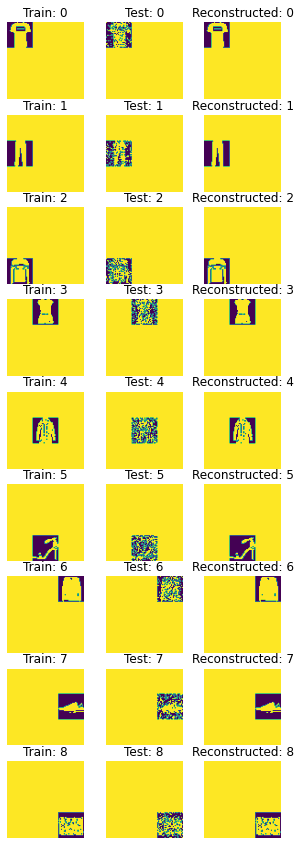

<Figure size 432x288 with 0 Axes>

In [12]:
# Display the results
fig, axs = plt.subplots(9, 3, figsize=(5, 15))
for i in range(9):
    axs[i, 0].imshow(train[i].reshape(ix,iy), cmap='viridis')
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Train: %i" % i)
    axs[i, 1].imshow(test[i].reshape(ix,iy), cmap='viridis')
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Test: %i" % i)
    axs[i, 2].imshow(reconstructed[i].reshape(ix,iy), cmap='viridis')
    axs[i, 2].axis('off')
    axs[i, 2].set_title("Reconstructed: %i" % i)

plt.show()
plt.tight_layout()


In [13]:
def calculate_accuracy(test_images, reconstructed_images):
    accuracy = []
    for i in range(len(test_images)):
        
        accuracy.append(np.sum(test_images[i] == reconstructed_images[i]) / (84*84))
    
    return np.array(accuracy)

In [14]:

# Test the network with noised versions of the images, sweep noise variation from 0.2 to 2.0 in 0.3 steps
accuracy = []
for noise_ratio in np.arange(0.2, 2.0, 0.3):
    train, test = create_noise_image(trainImg, noise_ratio)
    reconstructed = test_model(w, test)
    acc = calculate_accuracy(train, reconstructed)
    accuracy.append(np.array(acc).mean())

accuracy = np.array(accuracy)

100%|██████████| 9/9 [00:00<00:00, 24.59it/s]


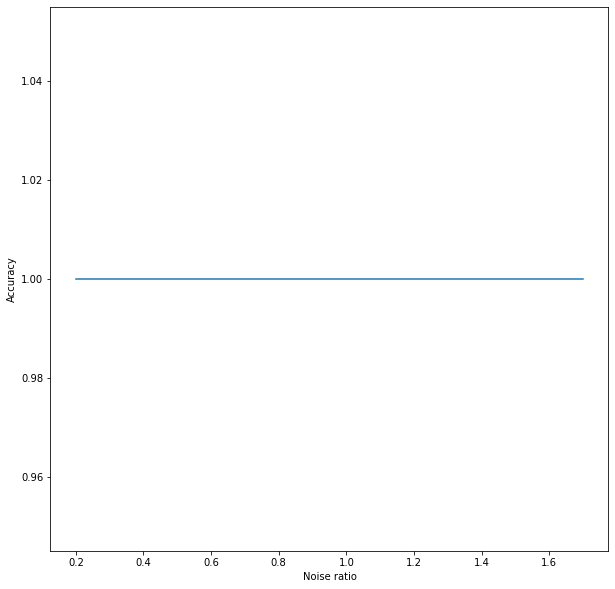

In [15]:
# Plot the accuracy
plt.figure(figsize=(10, 10))
plt.plot(np.arange(0.2, 2.0, 0.3), accuracy)
plt.xlabel("Noise ratio")
plt.ylabel("Accuracy")
plt.show()

As we can see, the model works very well for all the noise levels. This is due to the threshold offset we added earlier

100%|██████████| 9/9 [00:00<00:00, 21.51it/s]


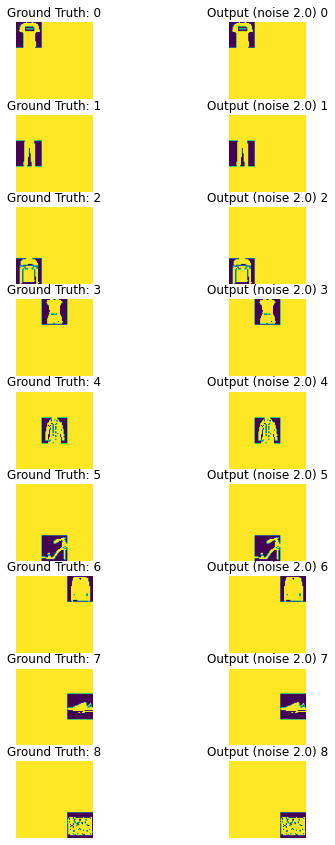

<Figure size 432x288 with 0 Axes>

In [16]:
# display train and test images for a gaussian noise ratio of 0.2, 1 and 2

fig, axs = plt.subplots(9, 2, figsize=(7, 15))

train, test = create_noise_image(trainImg, 2.0)
reconstructed = test_model(w, test)

# Display the results
for i in range(9):
    axs[i, 0].imshow(train[i].reshape(ix,iy), cmap='viridis')
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Ground Truth: %i" % i)
    axs[i, 1].imshow(reconstructed[i].reshape(ix,iy), cmap='viridis')
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Output (noise 2.0) %i" % i)

plt.show()
plt.tight_layout()

# Hetero-associative

# Weight initialization

In [17]:
def create_output_format(images, number):
    output = []

    img=np.zeros([ix,iy])
    for k in range(9):
        j=(k + number + 1)%9
        img[(k%3)*28:((k%3)+1)*28,int(k/3)*28:((int(k/3))+1)*28]=imageprepare(images[j], 28, 28).reshape(28,28)

    output.append(img.copy())
    
    return np.array(output)

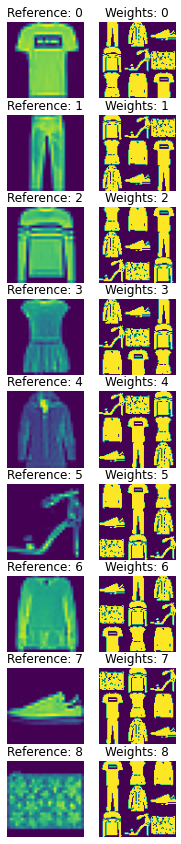

In [18]:
# display the output for every case:
fig, axs = plt.subplots(9, 2, figsize=(3, 15))

for i in range(9):
    out = create_output_format(trainImg, i)
    axs[i, 0].imshow(trainImg[i].reshape(28,28), cmap='viridis')
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Reference: %i" % i)
    axs[i, 1].imshow(out[0].reshape(ix,iy), cmap='viridis')
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Weights: %i" % i)

In [19]:
def train_hetero_model(train_images):
    
    w=np.zeros([num_neuron,num_neuron])
    rho=sum(sum(train_images))/(num_neuron*num_data)
    
    for i in tqdm(range(len(train_images))):
        imag=train_images[i]-rho
        imag2=create_output_format(trainImg, i)-rho
        imag2 = imag2.reshape(num_neuron)
        
        w+=np.einsum('i,j->ij',imag2, imag)
        
    diagW = np.diag(np.diag(w))
    w = w - diagW
    w /= num_data

    return w

In [20]:
w2 = train_hetero_model(train)

100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


# Network test

For the testing, we also added a decision threshold offset like done before, for similar reasons.

100%|██████████| 9/9 [00:00<00:00, 22.50it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

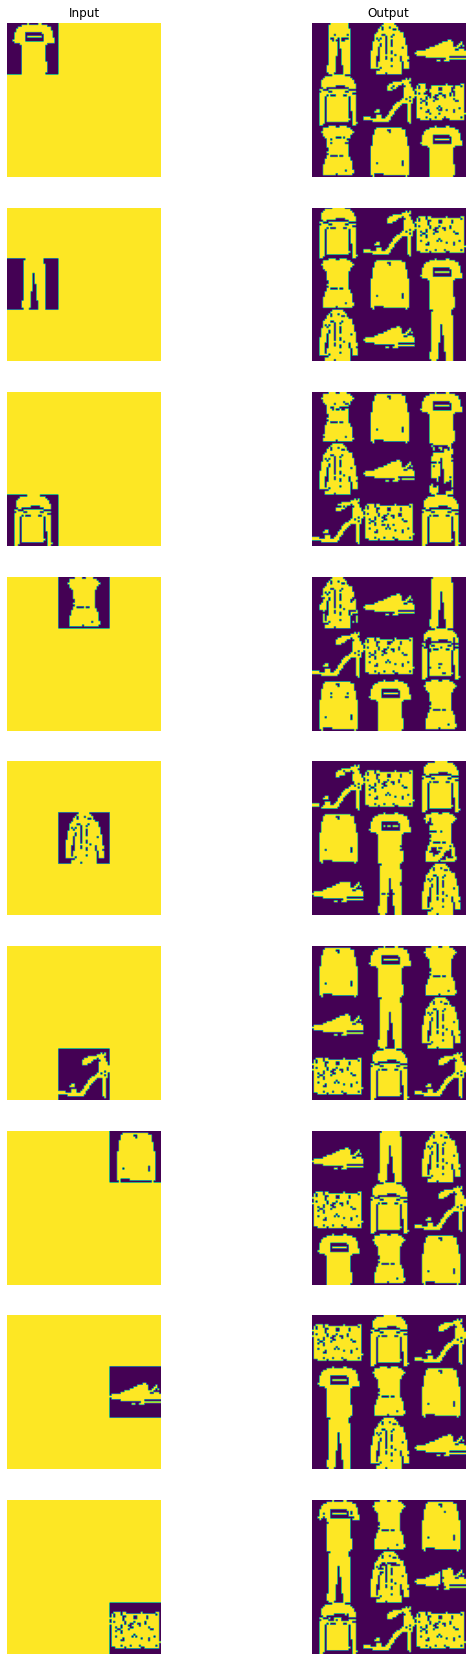

In [21]:
out=[]

for i in tqdm(range(len(train))):
    testr=np.copy(train[i])
    for j in range(it):
        out_weights = w2@testr
        offset = out_weights.mean() - out_weights.min()
        testr=np.sign(out_weights + offset/6)
    out.append(testr)

out=np.array(out)

# increase figure size
fig, axs = plt.subplots(9, 2, figsize=(10, 30))
for i in range(len(train)):
    axs[i,0].imshow(train[i].reshape(84,84),cmap='viridis'); axs[i,0].axis('off'); 
    if(i==0):axs[i,0].set_title('Input');
    axs[i,1].imshow(out[i].reshape(84,84),cmap='viridis'); axs[i,1].axis('off'); 
    if(i==0):axs[i,1].set_title('Output');
plt.show

As we can see, the model works perfectly